# Tianqi Part

## Importing Data

In [1]:
import pandas as pd

#Load movie reviews dataset
df = pd.read_csv( 'data/fake_or_real_news.csv', nrows=100000)
title = df.title.values
text = df.text.values
label = df.label.values


In [2]:
label

array(['FAKE', 'FAKE', 'REAL', ..., 'FAKE', 'REAL', 'REAL'], dtype=object)

In [3]:
#Find whether a Str is just a number
def is_number(s):
    try: 
        float(s)
        return True
    except ValueError:  
        pass 
    try:
        import unicodedata  
        unicodedata.numeric(s)  
        return True
    except (TypeError, ValueError):
        pass
    return False


#Find whether a Str contain English words or just meanless symbols
def containenglish(str0):
    import re
    return bool(re.search('[a-z]', str0))

## Clean non-English news

In [4]:
def ChangeLabel(tryText):
    if tryText == 'FAKE':
        return 0
    elif tryText == 'REAL':
        return 1

In [5]:
from langdetect import detect
import types
#Separatly get Text with label and Tile with label
Text_list = []
Text_label = []
#clean text
for i in range(len(text)): 
    if containenglish(text[i]) == True:
        if (detect(text[i]) == 'en'):
            Text_list.append(text[i])
            Text_label.append(ChangeLabel(label[i]))


In [7]:
#clean text and title
Sum_label = []
Title_list = []
for i in range(len(text)): 
    if containenglish(text[i]) == True and containenglish(title[i]) == True:
        if (detect(text[i]) == 'en') and (detect(title[i]) == 'en'):
            Sum_label.append(ChangeLabel(label[i]))
            Title_list.append(title[i]+text[i])


## Show TURE news and FAKE news fraction

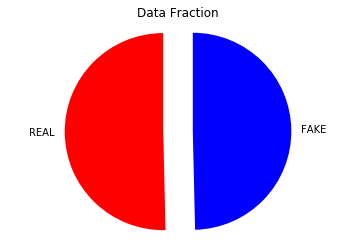

In [38]:
number_real = 0
for i in Text_label:
    if i == 1:
        number_real = number_real + 1
AllLabel = len(Text_label)
fracREAL = number_real/AllLabel
fracFAKE = 1 - fracREAL

labels = ['REAL', 'FAKE']
values = [fracREAL, fracFAKE]
colors = ['red','blue']
explode = [0.3,0]

plt.title('Data Fraction')
plt.pie(values,labels=labels,colors=colors,explode=explode,startangle=90)

plt.axis('equal')
plt.show()

In [8]:
import nltk
# Transform each review string as a list of token strings. Use text here because text is as same as Eng_list
tokenized = [nltk.word_tokenize(review) for review in Text_list]
tokenized_title = [nltk.word_tokenize(review) for review in Title_list]

## Clean stopwords and punctuation

In [10]:
from nltk.corpus import stopwords
from string import punctuation
from itertools import chain

def clean_text(tokenized_list, sw, punct, lemmatize=False):
    new_list = []
    for doc in tokenized_list:
        new_list.append([token.lower() for token in doc if token.lower() not in chain(punct, sw)])
    return new_list

# Remove punctuations and stopwords, and lower-case text
sw = stopwords.words('english')
punct = punctuation
cleaned = clean_text(tokenized, sw, punct)
cleaned_title = clean_text(tokenized_title, sw, punct)

## Clean meanless symbols and url

In [11]:
import re
for idx in range(len(cleaned)):
    cleaned[idx] = re.sub(r'@([A-Za-z0-9_]+)', "", str(cleaned[idx]))
    cleaned[idx] = re.sub(r"(https|http)\S+", "", str(cleaned[idx]))
    cleaned[idx] = re.sub(r"”|’|“|–|—", "", str(cleaned[idx]))
    
for idx in range(len(cleaned_title)):
    cleaned_title[idx] = re.sub(r'@([A-Za-z0-9_]+)', "", str(cleaned_title[idx]))
    cleaned_title[idx] = re.sub(r"(https|http)\S+", "", str(cleaned_title[idx]))
    cleaned_title[idx] = re.sub(r"”|’|“|–|—", "", str(cleaned_title[idx]))

In [12]:
import spacy
nlp = spacy.load('en_core_web_sm')
# Update puncuation list in spacy
nlp.vocab["$"].is_punct = True
nlp.vocab["|"].is_punct = True
nlp.vocab["+"].is_punct = True
nlp.vocab["<"].is_punct = True
nlp.vocab[">"].is_punct = True
nlp.vocab["="].is_punct = True
nlp.vocab["^"].is_punct = True
nlp.vocab["`"].is_punct = True
nlp.vocab["~"].is_stop = True
nlp.vocab["s"].is_stop = True
#nlp.vocab["t"].is_stop = True # change to not

## Lemmatize text 

In [13]:
# helper function to eliminate tokens that are pure punctuation, whitespace, or stopword
# can be updated based on desired filtering 

def process_txt(token):
    return token.is_punct or token.is_space or token.is_stop or token.like_num

In [14]:
# function to take array of articles and turn them into nested list of tokens
def lemmatize_txt(array):
    lemma = []
    
    for doc in nlp.pipe(array, batch_size=50,
                        n_threads=-1):
        if doc.is_parsed:
            lemma.append([n.lemma_ for n in doc if not process_txt(n)])
        
        else:
            lemma.append(None)
    
    return lemma

In [15]:
# Create nested list of tokens for each article
lem = lemmatize_txt(cleaned)
lem_title = lemmatize_txt(cleaned_title)

## Convert list of list to list of string

In [16]:
newLem = []
newLem_title = []
for doc in lem: 
    finalString = ', '.join(doc)
    newLem.append(finalString)
    
for doc in lem_title: 
    finalString = ', '.join(doc)
    newLem_title.append(finalString)

# Jiahao Part

## preprocessing the text， using TF-IDF

In [18]:
#validation set

#split data into training set and test set
from sklearn.model_selection import train_test_split

X1 = newLem
Y1 = Text_label
X2 = newLem_title
Y2 = Sum_label
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size = 0.33, stratify = Y1)

x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size = 0.33, stratify = Y2)

In [19]:
#build the model
from sklearn.feature_extraction.text import TfidfVectorizer
tdf1 = TfidfVectorizer()
tdf2 = TfidfVectorizer()
x_tfidf_train1 = tdf1.fit_transform(x_train1)
x_tfidf_test1 = tdf1.transform(x_test1)
x_tfidf_train2 = tdf2.fit_transform(x_train2)
x_tfidf_test2 = tdf2.transform(x_test2)

In [20]:
#assess this model,using naive bayes
from sklearn.naive_bayes import MultinomialNB
tdf_model = MultinomialNB().fit(x_tfidf_train1, y_train1)
train_score = tdf_model.score(x_tfidf_train1, y_train1)
test_score = tdf_model.score(x_tfidf_test1, y_test1)
print(train_score)
print(test_score)

0.8942376096751244
0.8431183830606352


## preprocessing the text， using doc2vec

In [21]:
#build the dictionary and corpus
from gensim import corpora

dictionary1 = corpora.Dictionary([cleaned])
dictionary2 = corpora.Dictionary([cleaned_title])
corpus1 = [dictionary1.doc2bow([text]) for text in cleaned]
corpus2 = [dictionary2.doc2bow([text]) for text in cleaned_title]

In [22]:
#Build a vocabulary
from gensim.models.doc2vec import TaggedDocument
vocabulary1 = [TaggedDocument(doc, tags=[idx]) for idx, doc in enumerate(cleaned)]
vocabulary2 = [TaggedDocument(doc, tags=[idx]) for idx, doc in enumerate(cleaned_title)]

In [24]:
from gensim.models import Doc2Vec
import numpy as np
doc2vec1 = Doc2Vec(vector_size=300, window=5, min_count=5, dm = 1, epochs=10)
doc2vec2 = Doc2Vec(vector_size=300, window=5, min_count=5, dm = 1, epochs=10)
doc2vec1.build_vocab(vocabulary1)
doc2vec2.build_vocab(vocabulary2)

#Train the d2v model
doc2vec1.train(vocabulary1, epochs=10, total_examples=doc2vec1.corpus_count)
doc2vec2.train(vocabulary2, epochs=10, total_examples=doc2vec2.corpus_count)

#Build a new matrix that can fit classifier
doc2vec_list1 = np.zeros((len(cleaned),300))
doc2vec_list2 = np.zeros((len(cleaned_title),300))
for i in range (len(cleaned)):
    doc2vec_list1[i] = doc2vec1.infer_vector([cleaned[i]])
    
for i in range (len(cleaned_title)):
    doc2vec_list2[i] = doc2vec2.infer_vector([cleaned_title[i]])


In [25]:
X1 = doc2vec_list1
Y1 = Text_label
X2 = doc2vec_list2
Y2 = Sum_label
x_train1, x_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size = 0.33, stratify = Y1)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, Y2, test_size = 0.33, stratify = Y2)

# Hongyu Part

## Xgboost Classfier

In [26]:
conda install -c conda-forge xgboost

Solving environment: ...working... failed



PackagesNotFoundError: The following packages are not available from current channels:

  - xgboost

Current channels:

  - https://conda.anaconda.org/conda-forge/win-64
  - https://conda.anaconda.org/conda-forge/noarch
  - https://repo.anaconda.com/pkgs/main/win-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/win-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://repo.anaconda.com/pkgs/msys2/win-64
  - https://repo.anaconda.com/pkgs/msys2/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.





Note: you may need to restart the kernel to use updated packages.


In [27]:
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [28]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(x_train2, y_train2)

y_pred = model.predict(x_test2)

# check the accuracy on the training set
model.score(x_test2, y_test2)

C:\Users\pipi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5055387713997986

In [29]:
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.metrics import classification_report
from xgboost import XGBClassifier

XGmodel = XGBClassifier(max_depth=10, learning_rate=0.3, 
                        n_estimators=1000, silent=True, 
                        objective='binary:logistic', nthread=-1, 
                        gamma=0, min_child_weight=1, max_delta_step=0, 
                        subsample=0.7, colsample_bytree=1, 
                        colsample_bylevel=1, reg_alpha=0,            
                        reg_lambda=1, scale_pos_weight=1, 
                        base_score=0.5, seed=0, missing=None)

XGmodel.fit(x_train2, y_train2)

y_pred = XGmodel.predict(x_test2)

target_names = ['Not Admitted', 'Admitted']

print(classification_report(y_test2, y_pred, target_names=target_names))

              precision    recall  f1-score   support

Not Admitted       0.49      0.46      0.47       982
    Admitted       0.50      0.53      0.52      1004

   micro avg       0.49      0.49      0.49      1986
   macro avg       0.49      0.49      0.49      1986
weighted avg       0.49      0.49      0.49      1986

